In [1]:
# models
from n2v import N2VModel
from s2v import S2VModel
from netra import NetRAModel

# utility
import numpy as np
import argparse
import matplotlib.pyplot as plt
from util import data_util as du
from util import vis
from util import parameters
import main

# arguments
params_run = parameters.get_parameters(notebook=True)

In [2]:
# params_run.generate_data = True
# params_run.n_missing_edges = 2
# params_run.n_spurious_edges = 2
# params_run.gen_data = 2
# main.run(params_run)

## Select run

Select run to visualise

In [69]:
import os

class RunData:
    def __init__(self, selected_run):
        self.data_path = os.path.join('results', selected_run, 'data')
        self.model_output = os.path.join('results', selected_run, 'model_output')
        self.plots_path = os.path.join('results', selected_run, 'plots')

        # load all data
        self.params = parameters.Parameters(du.read_params(os.path.join(self.data_path, 'params_run.bin')))
        self.bootstrap_preds_all = du.read_pickle(os.path.join(self.data_path, 'bootstrap_preds_all.bin'))
        self.bootstrap_preds_missing = du.read_pickle(os.path.join(self.data_path, 'bootstrap_preds_missing.bin'))
        self.bootstrap_preds_spurious = du.read_pickle(os.path.join(self.data_path, 'bootstrap_preds_spurious.bin'))
        self.fit_negative_samples = du.read_pickle(os.path.join(self.data_path, 'fit_negative_samples.bin'))
        self.missing = du.read_pickle(os.path.join(self.data_path, 'missing.bin'))
        self.score_negative_samples = du.read_pickle(os.path.join(self.data_path, 'score_negative_samples.bin'))
        self.spurious = du.read_pickle(os.path.join(self.data_path, 'spurious.bin'))
        self.train_data = du.load_edge_list(os.path.join(self.data_path, 'train_data.edgelist'), self.params.directed)

        # load model
        self.model = du.read_pickle(os.path.join(self.model_output, 'model.bin'))

available_runs = sorted(os.listdir('results/'))
# for idx,available in enumerate(available_runs):
#     metadata = du.read_params(os.path.join('results', available, 'data', 'params_run.bin'))
#     print(f'{available}:', metadata)
print(available_runs)
selected_run = available_runs[5]
rd = RunData(selected_run)

['20210311-154933', '20210311-170912', '20210311-170938', '20210311-171117', '20210311-171140', '20210311-171317']


## Loading Data
Show true data and noisy data for current run

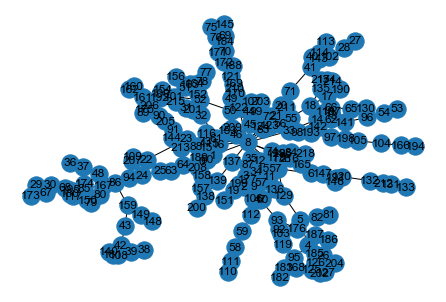

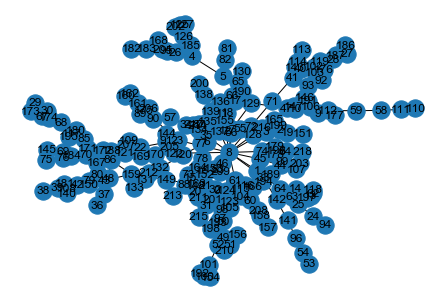

In [70]:
from util import vis
# show data
data = du.load_edge_list(rd.params.input_data, rd.params.directed)
v = vis.vis_graph(data)
plt.show(v)

v = vis.vis_graph(rd.train_data)
plt.show(v)

## Edge Embeddings
As we can see in the visualisations below, embeddings are defined for all possible edges, not just edges that exist in the graph. However, directionality is discarded after embedding. Due to the nature of the implemented edge embeddings, an edge from node 1 to node 2 will output the same edge embedding as an edge from node 2 to node 1. For example, the Hadamard embedding will multiply the node embeddings of node 1 and node 2 together. More info at this link: https://github.com/eliorc/node2vec/issues/36

In [58]:
print('Nodes')
fig2dnodes = vis.vis_embeddings(rd.model.nodes.vectors)
plt.show()

print('Edges')
edge_labels = du.construct_embedding_labels(data, rd.model.ee_kv)
embeddings2dedges = vis.vis_edge_embeddings(data, rd.model.ee_kv.vectors, edge_labels)
plt.show()

Nodes


AttributeError: 'dict' object has no attribute 'vectors'

## plots
Classify points

(20, 1, 2)


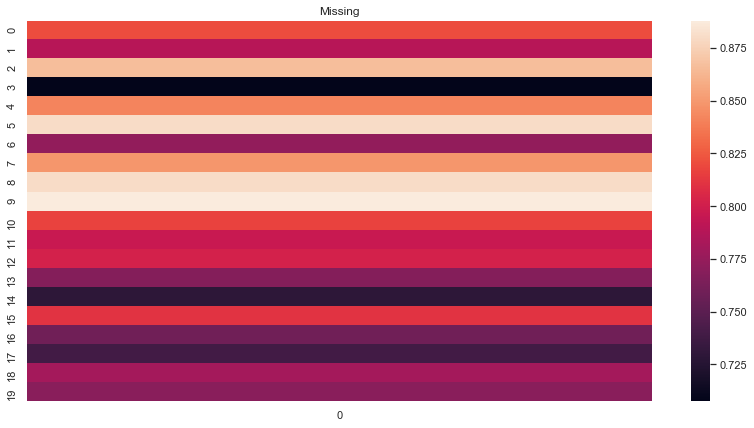

In [74]:
import pandas as pd

# missing
# set constants
num_runs = len(rd.bootstrap_preds_missing)
num_nodes = len(rd.bootstrap_preds_missing[0])

# unpack values
all_runs_missing_preds, missing_edge_names, _ = du.unpack_values(rd.bootstrap_preds_missing)
print(all_runs_missing_preds.shape)
all_runs_missing_preds = all_runs_missing_preds[:, :, 1]

all_runs_negative_fit_labels, all_runs_negative_fit = du.unpack_neg_samples(rd.score_negative_samples)

men = []
for edge in missing_edge_names:
    for neg_run in all_runs_negative_fit_labels:
        for label_used in neg_run:
            label_used_str = str([label_used[0], label_used[1]])
            men.append(label_used_str)
            if str(edge) == label_used_str:
                print(f'edge {edge} sampled for fit')

# sort columns
# print(all_runs_missing_preds)
# print(men)
# all_runs_missing_preds = pd.DataFrame(data=all_runs_missing_preds)
# totals = all_runs_missing_preds.sum(axis=0)
# all_runs_missing_preds = all_runs_missing_preds.append(totals, ignore_index=True).sort_values(num_runs, axis=1).drop(index=num_runs)

# plot heatmap
fig = vis.plot_heatmap(all_runs_missing_preds, fname=f'{rd.params.model_type}_missing.png', dirname=rd.plots_path, figsize=(14,7))
plt.title('Missing')
plt.show(fig)

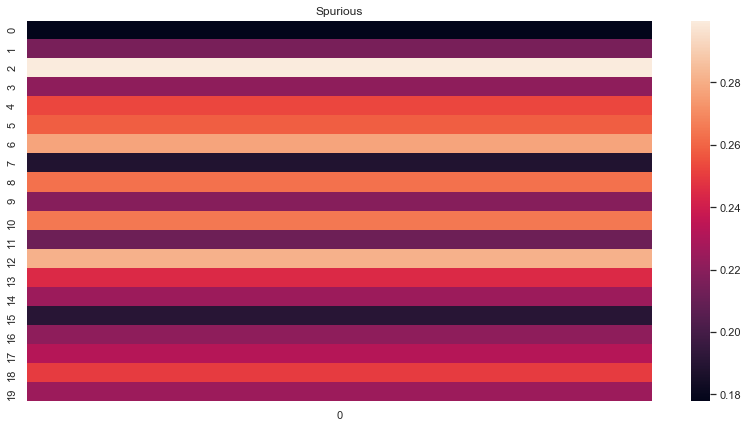

In [75]:
# spurious
# set constants
num_runs = len(rd.bootstrap_preds_spurious)
num_nodes = len(rd.bootstrap_preds_spurious[0])

# unpack values
all_runs_spurious_preds, spurious_edge_names, _ = du.unpack_values(rd.bootstrap_preds_spurious)
all_runs_spurious_preds = all_runs_spurious_preds[:, :, 0]

# sort columns
# all_runs_spurious_preds = pd.DataFrame(data=all_runs_spurious_preds, columns=spurious_edge_names)
# totals = all_runs_spurious_preds.sum(axis=0)
# all_runs_spurious_preds = all_runs_spurious_preds.append(totals, ignore_index=True).sort_values(num_runs, axis=1).drop(index=num_runs)

# plot heatmap
fig = vis.plot_heatmap(all_runs_spurious_preds, fname=f'{rd.params.model_type}_spurious.png', dirname=rd.plots_path, figsize=(14,7))
plt.title('Spurious')
plt.show(fig)

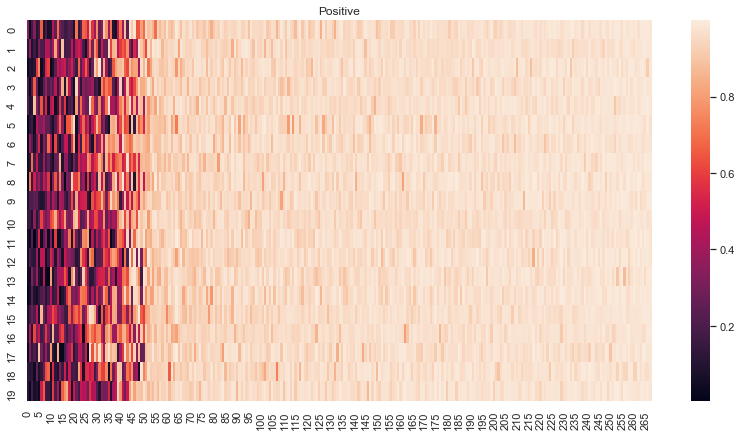

In [43]:
# full
# set constants
num_runs = len(rd.bootstrap_preds_all)
num_nodes = len(rd.bootstrap_preds_all[0])

# unpack values
all_runs_full_preds, full_edge_names, full_labels = du.unpack_values(rd.bootstrap_preds_all)

# filter predictions by label
all_runs_full_preds = du.filter_preds_by_label(all_runs_full_preds, full_labels)

# sort columns
all_runs_full_preds = pd.DataFrame(data=all_runs_full_preds, columns=full_edge_names)
totals = all_runs_full_preds.sum(axis=0)
all_runs_full_preds = all_runs_full_preds.append(totals, ignore_index=True).sort_values(num_runs, axis=1).drop(index=num_runs)


# plot heatmap
fig = vis.plot_heatmap(all_runs_full_preds.to_numpy(), fname=f'{rd.params.model_type}_full.png', dirname=rd.plots_path, figsize=(14,7))
plt.title('Positive')
plt.show(fig)

In [ ]:
import seaborn as sns
thresh = 0.5
# noisy samples
print("NOISY SAMPLES")

# MISSING
print("MISSING")
num_runs = len(rd.bootstrap_preds_missing)
num_nodes = len(rd.bootstrap_preds_missing[0])
all_runs_missing_preds, missing_edge_names, _ = du.unpack_values(rd.bootstrap_preds_missing)
# probablistic
correct_missing = np.sum(all_runs_missing_preds[:, :, 1])
total_missing = num_runs * num_nodes
ratio_missing = correct_missing / float(total_missing)
# thresholded
true_positive_missing = np.sum(all_runs_missing_preds[:, :, 1] > thresh) 
false_negative_missing = total_missing - true_positive_missing
print('correct: ', correct_missing, ', total mass:', total_missing, ', ratio: ', ratio_missing)
print('tp', true_positive_missing, 'fn', false_negative_missing)

# SPURIOUS
print("SPURIOUS")
num_runs = len(rd.bootstrap_preds_spurious)
num_nodes = len(rd.bootstrap_preds_spurious[0])
all_runs_spurious_preds, spurious_edge_names, _ = du.unpack_values(rd.bootstrap_preds_spurious)
# probablistic
correct_spurious = np.sum(all_runs_spurious_preds[:, :, 0])
total_spurious = num_runs * num_nodes
ratio_spurious = correct_spurious / float(total_spurious)
# thresholded
true_negative_spurious = np.sum(all_runs_spurious_preds[:, :, 0] > thresh) 
false_positive_spurious = total_spurious - true_negative_spurious
print('correct: ', correct_spurious, ', total mass:', total_spurious, ', ratio: ', ratio_spurious)
print('tn', true_negative_spurious, 'fp', false_positive_spurious)

# plot cf matrix
print('tp', true_positive_missing, 'tn', true_negative_spurious, 'fp', false_positive_spurious, 'fn', false_negative_missing)
ax = sns.heatmap([[true_negative_spurious, false_negative_missing],[false_positive_spurious, true_positive_missing]], annot=True)
ax.set_ylabel('Predicted')
ax.set_xlabel('True')
plt.show(ax)

In [ ]:
# FULL
print("FULL")
import seaborn as sns
thresh = 0.5
num_runs = len(rd.bootstrap_preds_all)
num_nodes = len(rd.bootstrap_preds_all[0])

# unpack values
all_runs_full_preds, full_edge_names, full_labels = du.unpack_values(rd.bootstrap_preds_all)

# filter predictions by label
filtered = du.filter_preds_by_label(all_runs_full_preds, full_labels)

# probablistic
correct = np.sum(filtered)
total = num_runs * num_nodes
ratio = correct / float(total)

# get positive/negative indices
positive_indices = np.where(np.array(full_labels).astype(int) == 1)
negative_indices = np.where(np.array(full_labels).astype(int) == 0)

# get number of tp/tn/fp/fn
print('totals', len(filtered[positive_indices]), len(filtered[negative_indices]))
true_positive = np.sum((filtered[positive_indices] > thresh))
true_negative = np.sum((filtered[negative_indices] > thresh))
false_negative = len(filtered[positive_indices]) - true_positive
false_positive = len(filtered[negative_indices]) - true_negative
print('correct: ', correct, ', total mass:', total, ', ratio: ', ratio)

# plot cf matrix
ax = sns.heatmap([[true_negative, false_negative],[false_negative, true_positive]], annot=True)
ax.set_ylabel('Predicted')
ax.set_xlabel('True')
plt.show(ax)

In [ ]:
# true_positive = 0
# true_negative = 0
# false_negative = 0
# false_positive = 0
# for edge_idx, labels in zip(range(len(full_edge_names)),full_labels[0]):
#     e1 = [str(node) for node in full_edge_names[edge_idx]]
#     similar = (rd.model.nodes.similarity(e1[0],e1[1]) > thresh).astype(int)
#     if labels == 1.0:
#         if similar == 1:
#             true_positive += 1
#         elif similar == 0:
#             false_negative += 1
#     elif labels == 0.0:
#         if similar == 1:
#             false_positive += 1
#         elif similar == 0:
#             true_negative += 1
# # print(du.tuple2edge_str(full_edge_names))

# # plot cf matrix
# ax = sns.heatmap([[true_negative, false_negative],[false_negative, true_positive]], annot=True)
# ax.set_ylabel('Predicted')
# ax.set_xlabel('True')
# plt.show(ax)